## MAPK transient vs. sustained EGF stimulus
*Nathaniel Linden - October 2023*

In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode

sys.path.append("./models/")
from shin_2014 import *
from shin_2014_transient import *


jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


## Helper functions
First we define a few help functions that will be used throughout the notebook.
They functions simulate a trajectory, and a steady-state.

In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    times = np.linspace(t0, t1, n_out)
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=60000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


## Shin 2014

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_8267/2049719680.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])


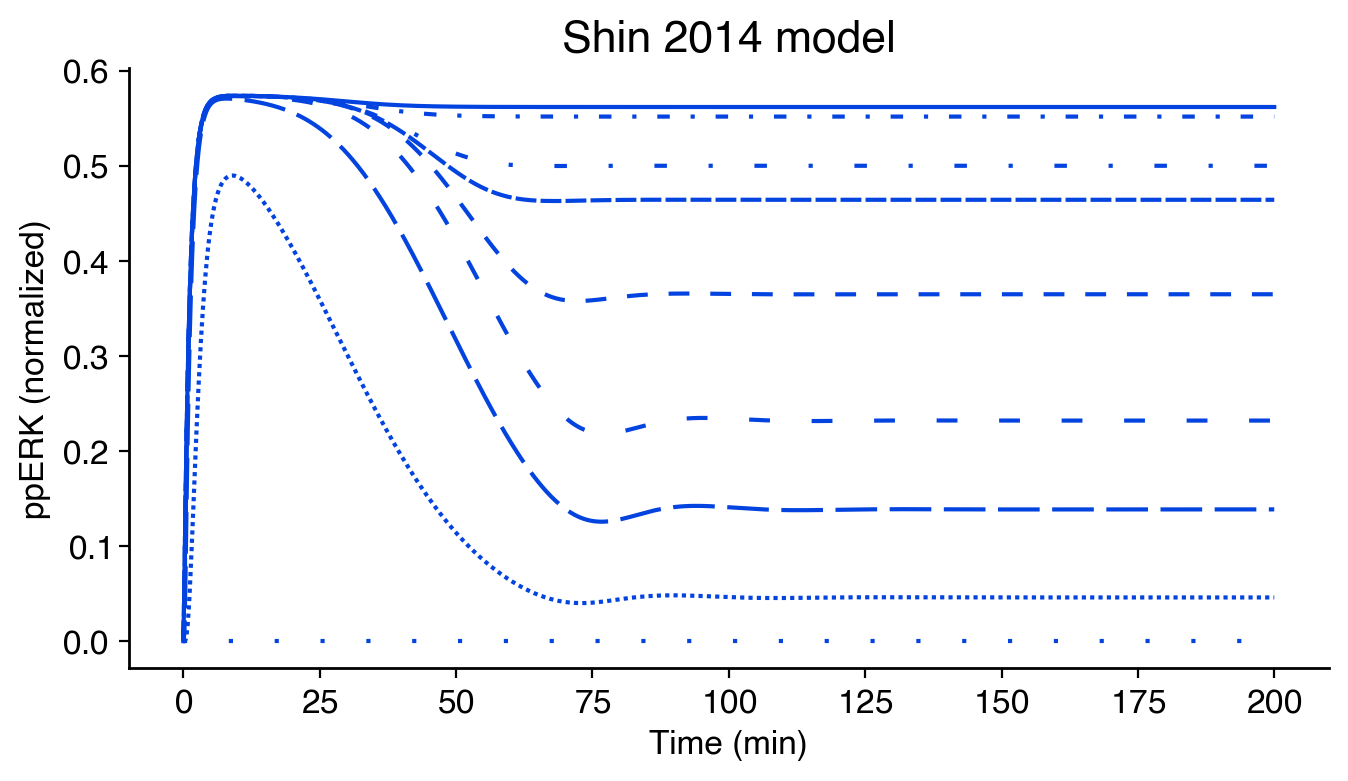

In [7]:
SN_2014 = shin_2014_transient(transient=False)
pdict, plist = SN_2014.get_nominal_params()
y0_dict, y0 = SN_2014.get_initial_conditions()

sols = {}
cols = ['xkcd:blue', 'xkcd:black', 'xkcd:indigo', 'xkcd:red', 'xkcd:gray', 'xkcd:brown', 'xkcd:pink', 'xkcd:gray', 'xkcd:dark yellow']

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     # ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('', '-'),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/S_2014'
for i, EGF in enumerate(EGFs):
    y0_dict['EGF'] = EGF
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(SN_2014, y0, plist, t1=200)
    sols[EGF] = sol

    ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
ax.set_title('Shin 2014 model')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
leg = ax.legend(fontsize=10, ncol=3)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

In [4]:
SN_2014_T = shin_2014_transient()
pdict_T, plist_T = SN_2014_T.get_nominal_params()
y0_dict_T, y0_T = SN_2014_T.get_initial_conditions()

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_8267/2896389658.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict_T['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])


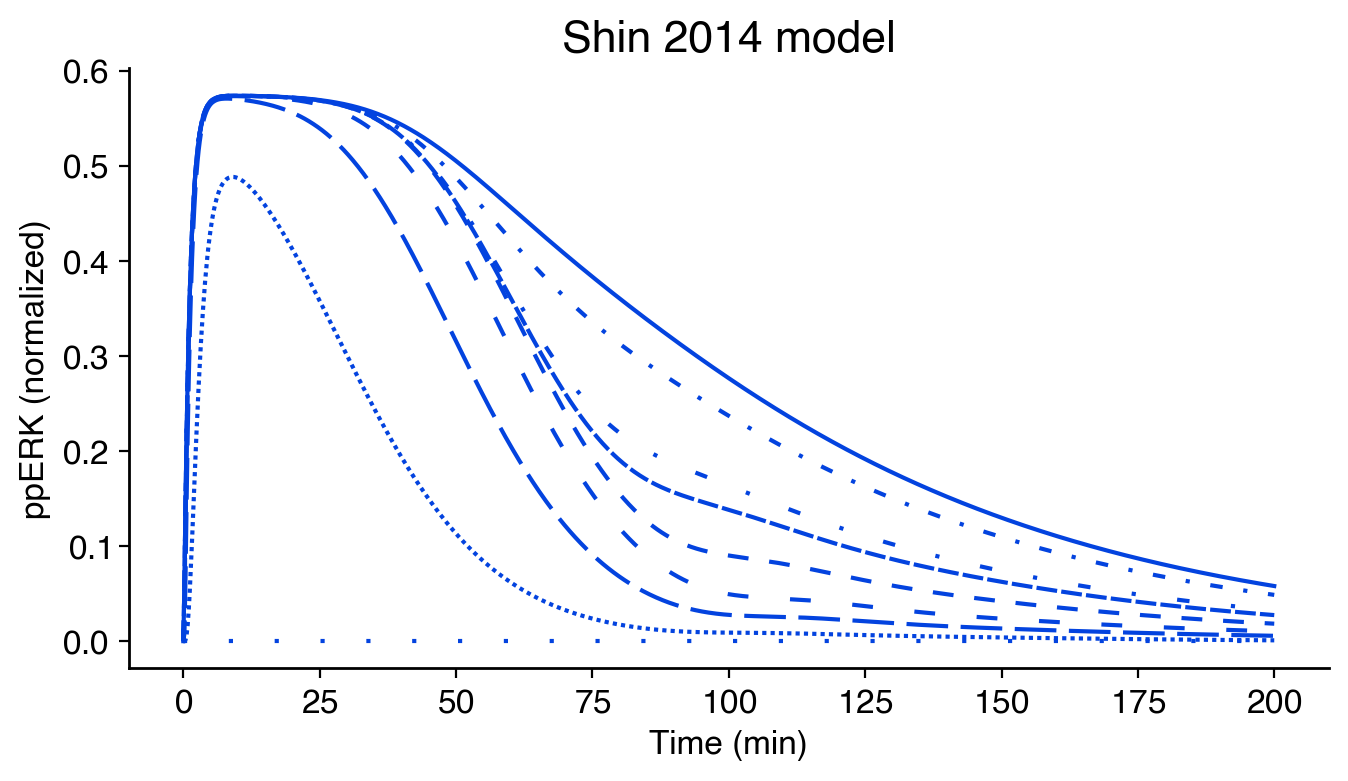

In [5]:
sols_T = {}
EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/S_2014'
for i, EGF in enumerate(EGFs):
    y0_dict_T['EGF'] = EGF
    y0_T = tuple([y0_dict_T[key] for key in y0_dict_T.keys()])
    sol = simulate_model_trajectory(SN_2014_T, y0_T, plist_T, t1=200)
    sols_T[EGF] = sol

    ax.plot(sol.ts, sol.ys[-1]/pdict_T['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
ax.set_title('Shin 2014 model')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
leg = ax.legend(fontsize=10, ncol=3)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)